# Varying Noise Experiment
In this notebook, we test our algorithm in setting where there is a lot of noise variance. We then compare our results to other methods on the same task.

In [1]:
import sys 
sys.path.append('..')

import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 
import IPython 

from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

TABLE_NAME = 'logs'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

In [40]:
args = Parameters({
    "samples": 1000, # number of samples to generate for ground-truth
    "c": 0, # left truncation parameter
    "bs": 100,
    "lr": 1e-1,
    'var_lr': 1e-1,
    "trials": 10,
    "steps": 5000,
    "x_lower": -10,  # lower bound for generating input features
    "x_upper": 10,  # upper bound for generating input features
    "lower": -1, # lower bound for generating ground-truth
    "upper": 1, # lower bound for generating ground-truth
#     'out_dir': '<FILL IN OUT_DIR HERE>' 
    'out_dir': '/Users/patroklos/Desktop/debug', 
#     'exp': '<FILL IN EXP HERE>', 
    'exp': 'Test', 
    'eps': 1e-2,
    'var': 5,  # maximum variance to use in procedure
    'step_lr': 100, 
    'step_lr_gamma': .9, 
    'tol': 1e-2, 
    'n': 100,
    'attempts': 3,
    'val': .1,
})

I will first begin, by showing how to use our algorithm in a 1 dimensional setting. I will sample input features from a Uniform distribution, I will also sample my ground-truth from a Uniform distribution, and I will add Gaussian noise with noise variance 10.

gt weight:  Parameter containing:
tensor([[0.4687]], requires_grad=True)
gt bias:  None
alpha:  tensor([0.5180])
gt ols coef:  [[0.43902642]]
gt ols intercept:  [0.12914973]
trunc ols coef:  [[0.19302198]]
trunc ols intercept:  [2.7832856]


Text(0, 0.5, 'y')

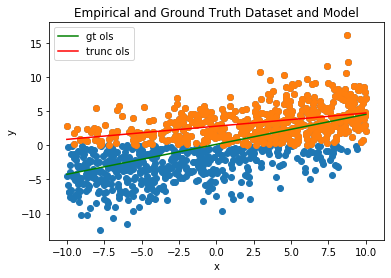

In [22]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(args.lower, args.upper)
m = Uniform(args.x_lower, args.x_upper)
phi = oracle.Left(Tensor([args.C]))

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([10.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(args.x_lower, args.x_upper, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to normalize our input features dataset. So, we divide all of our covariate features by $B\sqrt{k}$, so that $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. By doing this, the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [23]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(9.9984)
beta:  tensor(9.9984)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. 

Now, we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([4.8858])
trunc reg noise var:  tensor([1.])


Text(0, 0.5, 'y')

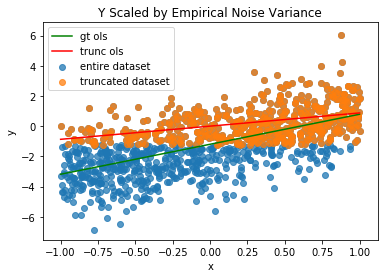

In [24]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = (y_trunc - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, (noised - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.4886])
reg noise var:  tensor([1.0474])


Text(0, 0.5, 'y')

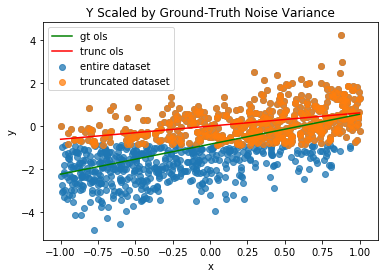

In [25]:
stand_noised, stand_y_trunc = (noised - trunc_ols.intercept_) / ch.sqrt(noise_var), (y_trunc - trunc_ols.intercept_) / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

We will now run our procedure for truncated regression with known variance, assuming that the empirical noise variance is the actual noise variance. Since we applied feature transformations to our truncated dataset, we now need to reverse the trnasformations after the completion of our procedure.

In [26]:
emp_scale_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(emp_noise_var))
known_emp_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=False, val=int(args.val*x_trunc.size(0)), bs=args.bs, n=args.n, tol=args.tol, steps=args.steps)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta
known_emp_bias_unnorm = known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration 1 | Score: 0.030513232573866844
Iteration 2 | Score: 0.05425021052360535
Iteration 3 | Score: 0.08177012205123901
Iteration 4 | Score: 0.07919140160083771
Iteration 5 | Score: 0.08114746958017349
Iteration 6 | Score: 0.07039141654968262
Iteration 7 | Score: 0.04746221750974655
Iteration 8 | Score: 0.05001576244831085
Iteration 9 | Score: 0.06351560354232788
Iteration 10 | Score: 0.07696059346199036
Iteration 11 | Score: 0.08656960725784302
Iteration 12 | Score: 0.07046366482973099
Iteration 13 | Score: 0.07556068897247314
Iteration 14 | Score: 0.07866262644529343
Iteration 15 | Score: 0.07046224176883698
Iteration 16 | Score: 0.07066860049962997
Iteration 17 | Score: 0.07190879434347153
Iteration 18 | Score: 0.05812779441475868
Iteration 19 | Score: 0.05694607272744179
Iteration 20 | Score: 0.05383449047803879
Iteration 21 | Score: 0.08335435390472412
Iteration 22 | Score: 0.04386955499649048
Iteration 23 | Score: 0.07930947840213776
Iteration 24 | Score: 0.08089127391576767


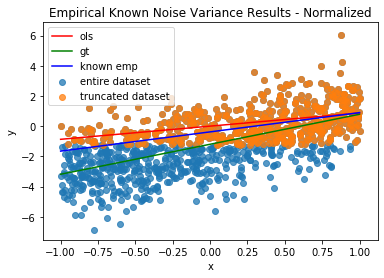

Text(0, 0.5, 'y')

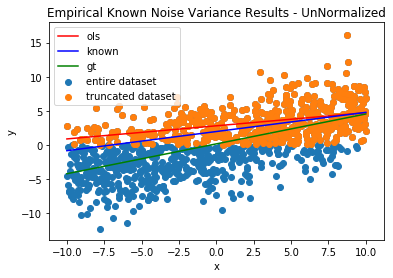

In [27]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')

plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

We now run our procedure for truncated regression with known variance, assuming that we are given the ground-truth noise variance.

In [38]:
stand_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(noise_var))
known_trunc_reg = TruncatedRegression(phi=stand_phi, alpha=alpha, unknown=False, val=100, bs=100, n=100, tol=1e-3, steps=5000, step_lr_gamma=1.0)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)

known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta
known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var) + trunc_ols.intercept_

Iteration 1 | Score: 0.04678833484649658
Iteration 2 | Score: 0.0048631709069013596
Iteration 3 | Score: 0.010330957360565662
Iteration 4 | Score: 0.003266880288720131
Iteration 5 | Score: 0.007420266047120094
Iteration 6 | Score: 0.004636451601982117
Iteration 7 | Score: 0.009059973061084747
Iteration 8 | Score: 0.006250149570405483
Iteration 9 | Score: 0.00198151171207428
Iteration 10 | Score: 0.008044367656111717
Iteration 11 | Score: 0.004232421517372131
Iteration 12 | Score: 0.0032507888972759247
Iteration 13 | Score: 0.0074392762035131454
Iteration 14 | Score: 0.008041932247579098
Iteration 15 | Score: 0.0011639967560768127
Iteration 16 | Score: 0.02732846327126026
Iteration 17 | Score: 0.00986318290233612
Iteration 18 | Score: 0.007382235489785671
Iteration 19 | Score: 0.002420494332909584
Iteration 20 | Score: 0.00628446601331234
Iteration 21 | Score: 0.014237620867788792
Iteration 22 | Score: 0.004203226417303085
Iteration 23 | Score: 0.002958487719297409
Iteration 24 | Score:

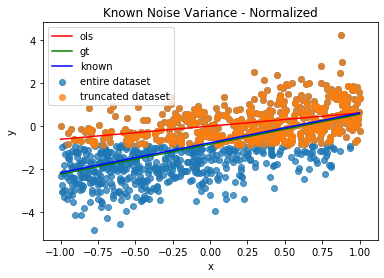

Text(0, 0.5, 'y')

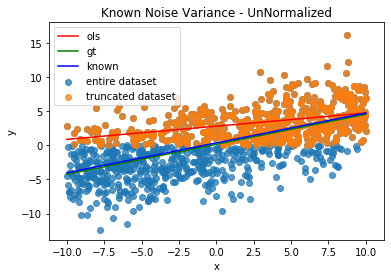

In [39]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
# plt.show()

Truncated Regression with Unknown Noise Variance

In [35]:
unknown_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=True, bs=100, n=100, tol=1e-2, val=100, steps=2000, step_lr_gamma=1.0)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

unknown_weight_unnorm = (unknown_trunc_reg.weight  * ch.sqrt(emp_noise_var)) / beta
unknown_bias_unnorm = unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration 1 | Score: 0.12396519631147385
Iteration 2 | Score: 0.10579610615968704
Iteration 3 | Score: 0.1255759298801422
Iteration 4 | Score: 0.13249166309833527
Iteration 5 | Score: 0.1099746823310852
Iteration 6 | Score: 0.15348072350025177
Iteration 7 | Score: 0.11853236705064774
Iteration 8 | Score: 0.15494759380817413
Iteration 9 | Score: 0.11341448873281479
Iteration 10 | Score: 0.11524873226881027
Iteration 11 | Score: 0.1259310096502304
Iteration 12 | Score: 0.12168976664543152
Iteration 13 | Score: 0.12659569084644318
Iteration 14 | Score: 0.126493439078331
Iteration 15 | Score: 0.1264445185661316
Iteration 16 | Score: 0.14518049359321594
Iteration 17 | Score: 0.107421875
Iteration 18 | Score: 0.1355956345796585
Iteration 19 | Score: 0.14803434908390045
Iteration 20 | Score: 0.11203936487436295


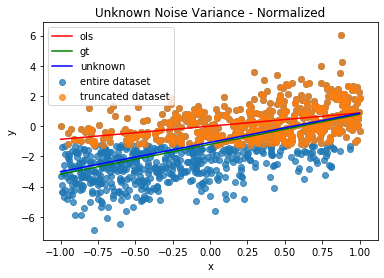

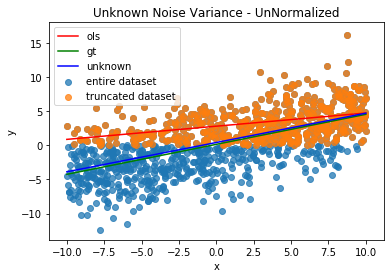

In [36]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [44]:
def run_trial(kwargs, X, y, tol, attempts):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > tol) and attempt < attempts:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

# Generate Ground-Truth and Run Experiment

In [45]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 10, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
phi = oracle.Left(0.0)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

# create base classifier
with ch.no_grad():
    # generate data
    X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
    y = gt(X)

In [ ]:
# create store and add table
store = Store(args.out_dir + '/' + args.exp)
store.add_table(TABLE_NAME, { 
    'ols_r2': float,
    'ols_param_mse': float,
    'ols_var_l1': float,
    'known_emp_r2': float,
    'known_emp_param_mse': float,
    'known_emp_time': int,
    'known_r2': float,
    'known_param_mse': float,
    'known_time': int,
    'unknown_r2': float, 
    'unknown_param_mse': float,
    'unknown_var_l1': float,
    'unknown_time': int,
    'trunc_reg_r2': float,
    'trunc_reg_param_mse': float, 
    'trunc_reg_var_mse': float,
    'trunc_reg_time': int,
    'alpha': float, 
    'num_samples': int,
    'noise_var': float, 
})

for i in range(args.trials):
    rand_noise = ch.randn(X.size(0), 1)
        
    for noise_var in range(1, args.var + 1): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var)*rand_noise
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        # mean for dependent variable
        y_trunc_mu = y_trunc.mean(0)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        val = int(args.val*x_trunc.size(0))
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(ols_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(emp_noise_var)
        
        emp_stand_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
        known_emp_kwargs = { 
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        known_emp_trunc_reg, total_time = run_trial(known_emp_kwargs, x_trunc_norm, emp_stand_y_trunc, args.tol, args.attempts)
        w, w0 = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, known_emp_trunc_reg.intercept[..., None] * ch.sqrt(emp_noise_var) + y_trunc_mu
        known_emp_params = ch.cat([w, w0]).flatten()

        # known emp results
        store[TABLE_NAME].update_row({
            'known_emp_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
            'known_emp_time': total_time, 
        })

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_noised = noised / ch.sqrt(noise_var)
        stand_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(noise_var))
    
        # run procedure until get reasonable score
        known_kwargs = { 
            'phi': stand_phi, 
            'alpha': alpha, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc, args.tol, args.attempts)
        w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var) + y_trunc_mu
        known_params = ch.cat([w, w0]).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
        })

        
        # truncated regression with unknown variance
        # run procedure until get reasonable score
        unknown_kwargs = { 
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'var_lr': args.var_lr,
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc, args.tol, args.attempts)
        unknown_var = unknown_trunc_reg.variance * emp_noise_var
        w, w0 = (unknown_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + y_trunc_mu
        unknown_params = ch.cat([w, w0]).flatten()
        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': total_time, 
        })
            
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(0), str(d), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(noised.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_mse': ch.abs(trunc_res[-1].pow(2)[None,...] - noise_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
            })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
        
        IPython.display.clear_output()

store.close()    

Final Score: 0.007165637798607349
Iteration 1 | Score: 0.1724635511636734
Iteration 2 | Score: 0.17918717861175537
Iteration 3 | Score: 0.1636635810136795
Iteration 4 | Score: 0.15977540612220764
Iteration 5 | Score: 0.1516696810722351
Iteration 6 | Score: 0.15629076957702637
Iteration 7 | Score: 0.13771212100982666
Iteration 8 | Score: 0.17490512132644653
Iteration 9 | Score: 0.1593935787677765
Iteration 10 | Score: 0.13872447609901428
Iteration 11 | Score: 0.1582818329334259
Iteration 12 | Score: 0.17319636046886444
Iteration 13 | Score: 0.1503230631351471
Iteration 14 | Score: 0.17526373267173767
Iteration 15 | Score: 0.14731571078300476
Iteration 16 | Score: 0.17593209445476532
Iteration 17 | Score: 0.1671256572008133
Iteration 18 | Score: 0.16005824506282806
Iteration 19 | Score: 0.14958232641220093
Iteration 20 | Score: 0.17784155905246735
Iteration 21 | Score: 0.15550419688224792
Iteration 22 | Score: 0.1533791422843933
Iteration 23 | Score: 0.16001102328300476
Iteration 24 | Sc

In [52]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head(10)

  0%|          | 0/2 [00:00<?, ?it/s]


ValueError: The file '/Users/patroklos/Desktop/debug/Test/c935c6b0-521e-4367-a88a-64702bd0114b/store.h5' is already opened, but not in read-only mode (as requested).

In [50]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'noise_var', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
#     temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
#     temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
#     temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
    
unknown_logs = unknown_logs.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [51]:
cols = ['known_param_mse', 'noise_var', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
#     temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
#     temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
#     temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [52]:
cols = ['known_emp_param_mse', 'noise_var', 'alpha']
known_emp_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
#     temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmax(), inplace=True)
#     temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmin(), inplace=True)
#     temp.drop(['index'], axis=1, inplace=True)
    known_emp_logs = pd.concat([known_emp_logs, temp])
known_emp_logs = known_emp_logs.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [53]:
cols = ['ols_param_mse', 'ols_var_l1', 'noise_var', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
#     temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)
#     temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmin(), inplace=True)
#     temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [54]:
cols = ['trunc_reg_param_mse', 'trunc_reg_var_mse', 'noise_var', 'alpha']
truncreg_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
#     temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_mse']].sum(1).idxmax(), inplace=True)
#     temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_mse']].sum(1).idxmin(), inplace=True)
#     temp.drop(['index'], axis=1, inplace=True)
    truncreg_logs = pd.concat([truncreg_logs, temp])
truncreg_logs = truncreg_logs.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [55]:
unknown_logs['unknown_epsilon'] = unknown_logs['unknown_param_mse'] + unknown_logs['unknown_var_l1']
truncreg_logs['trunc_reg_epsilon'] = truncreg_logs['trunc_reg_param_mse'] + truncreg_logs['trunc_reg_var_mse']
ols_logs['ols_epsilon'] = ols_logs['ols_param_mse'] + ols_logs['ols_var_l1']

In [56]:
unknown_logs['unknown_param_mse'] = unknown_logs['unknown_param_mse'] **(1/2)
known_logs['known_param_mse'] = known_logs['known_param_mse'] **(1/2)
ols_logs['ols_param_mse'] = ols_logs['ols_param_mse'] **(1/2)
known_emp_logs['known_emp_param_mse'] = known_emp_logs['known_emp_param_mse'] **(1/2)
truncreg_logs['trunc_reg_param_mse'] = truncreg_logs['trunc_reg_param_mse'] **(1/2)

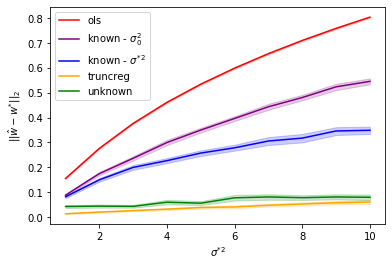

[Text(0, 0.5, '$|\\hat \\sigma^{2} - \\sigma^{*2}|$'),
 Text(0.5, 0, '$\\sigma^{*2}$')]

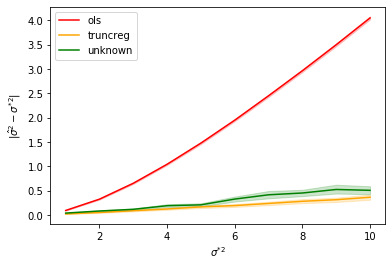

In [57]:
sns.lineplot(data=ols_logs, x='noise_var', y='ols_param_mse', label='ols', color='r')
sns.lineplot(data=known_emp_logs, x='noise_var', y='known_emp_param_mse', color='purple', label='known - $\sigma_{0}^{2}$')
sns.lineplot(data=known_logs, x='noise_var', y='known_param_mse', label='known - $\sigma^{*2}$', color='blue')
sns.lineplot(data=truncreg_logs, x='noise_var', y='trunc_reg_param_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_param_mse', label='unknown', color='green')

ax.set(xlabel='$\sigma^{*2}$', ylabel='$||\hat w - w^{*}||_{2}$')
plt.show()

sns.lineplot(data=ols_logs, x='noise_var', y='ols_var_l1', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='noise_var', y='trunc_reg_var_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_var_l1', label='unknown', color='green')
ax.set(xlabel='$\sigma^{*2}$', ylabel='$|\hat \sigma^{2} - \sigma^{*2}|$')

In [58]:
known_logs

,level_0,alpha,index,known_param_mse,noise_var
0,0,0.5014,0.0,0.082754,1.0
1,1,0.5036,10.0,0.093991,1.0
2,2,0.4998,20.0,0.083431,1.0
3,3,0.5026,30.0,0.096019,1.0
4,4,0.5058,40.0,0.091285,1.0
...,...,...,...,...,...
995,95,0.5118,959.0,0.353129,10.0
996,96,0.4952,969.0,0.382407,10.0
997,97,0.4940,979.0,0.288538,10.0
998,98,0.5106,989.0,0.333080,10.0


In [59]:
unknown_logs

,level_0,alpha,index,noise_var,unknown_param_mse,unknown_var_l1,unknown_epsilon
0,0,0.5014,0.0,1.0,0.067026,0.043086,0.047578
1,1,0.5036,10.0,1.0,0.131443,0.084219,0.101496
2,2,0.4998,20.0,1.0,0.029695,0.019916,0.020798
3,3,0.5026,30.0,1.0,0.037927,0.047678,0.049117
4,4,0.5058,40.0,1.0,0.008824,0.005286,0.005363
...,...,...,...,...,...,...,...
995,95,0.5118,959.0,10.0,0.069857,0.524914,0.529794
996,96,0.4952,969.0,10.0,0.091164,0.053529,0.061840
997,97,0.4940,979.0,10.0,0.055445,0.181155,0.184229
998,98,0.5106,989.0,10.0,0.101904,0.978078,0.988462
